## Import Libraries

In [15]:
working_dir = "../."
dataset_h5_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/clinical_eval/dataset.h5"
hospitaldict_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/clinical_eval/hospitals-patients-dict.pkl"
# dataset_h5_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/dataset.h5"
# hospitaldict_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/hospitals-patients-dict.pkl"
libraries_dir = working_dir + "/libraries"
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile
import pickle
import sys
import timm


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from kornia import tensor_to_image
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms import v2
from tqdm.notebook import tqdm

sys.path.append(working_dir)
# from data_setup import HDF5Dataset, FrameTargetDataset, DataAugmentation

os.chdir(working_dir)
os.getcwd()


print(f"Torch: {torch.__version__}")
# Training settings
batch_size = 4
epochs = 20
lr = 1e-4
gamma = 0.7
seed = 21
train_ratio = 0.7
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)
mps_device = torch.device('mps')
mps_device

Torch: 2.1.0


device(type='mps')

## Load Data

In [16]:
from torch.utils.data import Dataset, Subset
import os
import h5py
from tqdm import tqdm
import pickle
import random
import torchvision.transforms as transforms
from collections import defaultdict
import torch
import torch.nn as nn
import kornia.augmentation as K


# ---------------------------------------------------------------------------- #
#                                  HDF5Dataset                                 #
# ---------------------------------------------------------------------------- #


class HDF5Dataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        self.index_map_path = os.path.dirname(file_path) + "/index_map_" + os.path.splitext(os.path.basename(file_path))[0] + ".pkl"
        self.h5file = h5py.File(file_path, 'r')
        self.group_names = list(self.h5file.keys())
        self.total_videos = sum(len(self.h5file[group_name]) for group_name in self.group_names)
        self.check_for_index_map()
        #self.total_frames, self.frame_index_map = self.calculate_total_frames_and_index_map()

        print(f"\n{self.total_videos} videos ({self.total_frames} frames) loaded.")


    def check_for_index_map(self):
      """
      Check if the index map file exists and load it if found. 
      If not found, calculate the index map and save it to a pickle file.

      Parameters:
          None

      Returns:
          None
      """        
      try:
          with open(self.index_map_path, 'rb') as f:
              print("Serialized frame index map FOUND.\n")
              saved_data = pickle.load(f)
              self.total_frames = saved_data['total_frames']
              self.frame_index_map = saved_data['frame_index_map']
              print("Loaded serialized data.\n")
      except FileNotFoundError:
          print("Serialized frame index map NOT FOUND\n")
          self.total_frames, self.frame_index_map = self.calculate_total_frames_and_index_map()
          # Save calculated data to a pickle file
          with open(self.index_map_path, 'wb') as f:
              saved_data = {'total_frames': self.total_frames, 'frame_index_map': self.frame_index_map}
              pickle.dump(saved_data, f)
          print("\nIndex map calculated and saved")

    def calculate_total_frames_and_index_map(self):
        """
        Calculates the total number of frames and creates an index map for each frame.

        Returns:
            total_frames (int): The total number of frames.
            frame_index_map (dict): A dictionary mapping frame indices to their corresponding group and video names.
        """
        max_frame_idx_end = 0
        frame_index_map = {}

        # Create tqdm progress bar
        with tqdm(total=self.total_videos, desc="Calculating frames and index map", unit='video', dynamic_ncols=True) as pbar:
            for group_name in self.group_names:
                for video_name in self.h5file[group_name]:
                    video_group = self.h5file[group_name][video_name]
                    frame_idx_start = video_group.attrs['frame_idx_start']
                    frame_idx_end = video_group.attrs['frame_idx_end']
                    max_frame_idx_end = max(max_frame_idx_end, frame_idx_end)
                    for i in range(frame_idx_start, frame_idx_end + 1):
                        frame_index_map[i] = (group_name, video_name)
                    pbar.update(1)  # Update progress bar for each video

        total_frames = max_frame_idx_end + 1

        return total_frames, frame_index_map
      
      
    def split_dataset(self, pkl_file, rseed, train_ratio=0.7):
      """
      Split the dataset into training and test subsets based on a given pickle file.

      Parameters:
          pkl_file (str): The path to the pickle file.
          rseed (int): The seed for random number generation.
          train_ratio (float, optional): The ratio of data to be assigned to the training subset. Defaults to 0.7.

      Returns:
          train_dataset_subset (Subset): The training subset of the dataset.
          test_dataset_subset (Subset): The test subset of the dataset.
          split_info (dict): A dictionary containing various statistics and information about the split.

      Raises:
          FileNotFoundError: If the pickle file does not exist.

      """

      # Check if the pickle file exists
      if os.path.exists(pkl_file):
          # If the pickle file exists, load the data from it
          with open(pkl_file, 'rb') as f:
              data = pickle.load(f)
              medical_center_patients = data['medical_center_patients']
              data_index = data['data_index']
      else:
          # If the pickle file doesn't exist, create the data
          medical_center_patients = defaultdict(set)
          data_index = {}
          for index, (_, _, _, patient, medical_center) in enumerate(tqdm(self)):
              medical_center_patients[medical_center].add(patient)
              data_index[index] = (patient, medical_center)

          # Save the data to a pickle file
          data = {
              'medical_center_patients': medical_center_patients,
              'data_index': data_index
          }

          with open(pkl_file, 'wb') as f:
              pickle.dump(data, f)

      # Split the patients for each medical center
      train_indices = []
      test_indices = []

      # Lists to store statistics about medical centers and patients
      train_patients_by_center = defaultdict(set)
      test_patients_by_center = defaultdict(set)
      frame_counts_by_center = defaultdict(int)
      frame_counts_by_center_patient = defaultdict(lambda: defaultdict(int))

      for medical_center, patients in medical_center_patients.items():
          patients = list(patients)
          random.shuffle(patients)
          split_index = int(train_ratio * len(patients))

          for index, (patient, center) in data_index.items():
              if center == medical_center:
                  if patient in patients[:split_index]:
                      train_indices.append(index)
                      train_patients_by_center[medical_center].add(patient)
                  else:
                      test_indices.append(index)
                      test_patients_by_center[medical_center].add(patient)

                  frame_counts_by_center[medical_center] += 1
                  frame_counts_by_center_patient[medical_center][patient] += 1

      # Create training and test subsets
      train_dataset_subset = Subset(self, train_indices)
      test_dataset_subset = Subset(self, test_indices)

      # Sum up statistics info
      split_info = {
          'medical_center_patients': medical_center_patients,
          'frame_counts_by_center': frame_counts_by_center,
          'train_patients_by_center': train_patients_by_center,
          'test_patients_by_center': test_patients_by_center,
          'frame_counts_by_center_patient': frame_counts_by_center_patient,
          'total_train_frames': len(train_indices),
          'total_test_frames': len(test_indices)
      }

      return train_dataset_subset, test_dataset_subset, split_info, train_indices, test_indices
    
    
    def __len__(self):
        """
        Returns the total number of frames in the dataset.
        """
        return self.total_frames
    
    
    def __getitem__(self, index):
        """
        Retrieves the data for a specific frame at the given index.
    
        Args:
            index (int): The index of the frame to retrieve.
    
        Returns:
            tuple: A tuple containing the index, frame data, target data, patient, and medical center.
        Raises:
            IndexError: If the index is out of range.
        """
        if index < 0 or index >= self.total_frames:
            raise IndexError("Index out of range")
    
        group_name, video_name = self.frame_index_map[index]
        video_group = self.h5file[group_name][video_name]
        frame_data = video_group['frames'][f'frame_{index}'][:]
        target_data = video_group['targets'][f'target_{index}']
    
        # Get metadata
        patient = video_group.attrs['patient']
        medical_center = video_group.attrs['medical_center']
    
        return index, frame_data, target_data, patient, medical_center


# ---------------------------------------------------------------------------- #
#                              FrameTargetDataset                              #
# ---------------------------------------------------------------------------- #

# Custom replica class of the dataset to train the neural network (return -> [frame,target])
class FrameTargetDataset(Dataset):
    def __init__(self, hdf5_dataset, transform=None):
        """
        Initialize the dataset.

        Args:
            hdf5_dataset (h5py.Dataset): The HDF5 dataset.
        """
        self.hdf5_dataset = hdf5_dataset
        self.transform = transform
        self.resize_size = (224, 224)

    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
            int: The length of the dataset.
        """
        return len(self.hdf5_dataset)

    def __getitem__(self, index):
        """
        Get an item from the dataset.

        Args:
            index (int): The index of the item.

        Returns:
            tuple: A tuple containing the frame tensor and the target data.
        """
        _, frame_data, target_data, _, _ = self.hdf5_dataset[index]

        frame_tensor = self.pp_frames(frame_data)
        # frame_tensor = transforms.ToTensor()(frame_data)
        # frame_tensor = transforms.Resize(self.resize_size, antialias=True)(frame_tensor)
        # if self.transform is not None:
        #     frame_tensor = transforms.Normalize(mean=self.transform.image_mean, std=self.transform.image_std)(frame_tensor)
        # frame_tensor = frame_tensor.permute(0, 1, 2) # Move channels to the last dimension (needed after resize)
            
        # Target data to integer scores
        target_data = torch.tensor(sum(target_data))
        # target_data = int(target_data[()])

        

        return frame_tensor, target_data
    
    def set_transform(self, transform):
        self.transform = transform


    def pp_frames(self, frame_data):
        """
        Preprocess the frame data.

        Args:
            frame_data: The frame data.

        Returns:
            torch.Tensor: The preprocessed frame tensor.
        """

        size = (224, 224)
        image_mean = [0.485, 0.456, 0.406]
        image_std = [0.229, 0.224, 0.225]

        frame_tensor = v2.ToTensor()(frame_data)
        frame_tensor = v2.Resize(size)(frame_tensor)
        frame_tensor = v2.Normalize(mean=image_mean, std=image_std)(frame_tensor)

        return frame_tensor.permute(0, 1, 2)
      
      
# ---------------------------------------------------------------------------- #
#                               DataAugmentation                               #
# ---------------------------------------------------------------------------- #

class DataAugmentation(nn.Module):
    """Module to perform data augmentation using Kornia on torch tensors."""

    def __init__(self):
        super().__init__()
        # self.transforms = torch.nn.Sequential(
        #     K.RandomRotation(degrees=(-20, 20)),  # random rotation between -20 to 20 degrees
        #     K.RandomAffine(degrees=(-10, 10), scale=(0.8, 1.2))  # random affine transformation with rotation between -10 to 10 degrees and scale between 0.8 to 1.2
        # )
        self.transforms = torch.nn.Sequential(
            K.RandomRotation(degrees=(-25, 25)),  # random rotation between -20 to 20 degrees
            K.RandomElasticTransform(),
            K.RandomContrast(contrast = (0.5, 2.), p = 1.),
            K.RandomGaussianBlur((3, 3), (0.15, 3.0), p=1.)
        )

    @torch.no_grad()  # disable gradients for efficiency
    def forward(self, x):
        """Perform data augmentation on input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape BxCxHxW.

        Returns:
            torch.Tensor: Augmented tensor of shape BxCxHxW.
        """
        x_out = self.transforms(x)
        return x_out

In [17]:

dataset = HDF5Dataset(dataset_h5_path)

train_indices_path = os.path.dirname(dataset_h5_path) + f"/train_indices_{train_ratio}.pkl"
test_indices_path = os.path.dirname(dataset_h5_path) + f"/test_indices_{train_ratio}.pkl"


if os.path.exists(train_indices_path) and os.path.exists(test_indices_path):
    print("Loading pickled indices")
    with open(train_indices_path, 'rb') as train_pickle_file:
        train_indices = pickle.load(train_pickle_file)
    with open(test_indices_path, 'rb') as test_pickle_file:
        test_indices = pickle.load(test_pickle_file)
    # Create training and test subsets
    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)  
else:
    train_subset, test_subset, split_info, train_indices, test_indices = dataset.split_dataset(hospitaldict_path, 
                                                              seed, 
                                                              train_ratio)
    print("Pickling sets...")
    
    # Pickle the indices
    with open(train_indices_path, 'wb') as train_pickle_file:
        pickle.dump(train_indices, train_pickle_file)
    with open(test_indices_path, 'wb') as test_pickle_file:
        pickle.dump(test_indices, test_pickle_file)
        
        
# test_subset_size = train_ratio/2
# test_subset = Subset(test_subset, range(int(test_subset_size * len(test_indices))))
# test_subset


train_dataset = FrameTargetDataset(train_subset)
test_dataset = FrameTargetDataset(test_subset)

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")




Serialized frame index map FOUND.

Loaded serialized data.


60 videos (14545 frames) loaded.
Loading pickled indices
Train size: 8930
Test size: 5615


In [18]:
transform = DataAugmentation()

# train_dataset.set_transform(preprocess)
# test_dataset.set_transform(preprocess)

In [19]:
batch_size = 4

def collate_fn(examples):
    frames = torch.stack([example[0] for example in examples])  # Extract the preprocessed frames
    scores = torch.tensor([example[1] for example in examples])  # Extract the scores
    # return {"pixel_values": frames, "labels": scores}
    return (frames, scores)

train_dataloader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          num_workers=0,
                          pin_memory=True,
                          collate_fn=collate_fn, shuffle=False)

test_dataloader = DataLoader(test_dataset,
                          batch_size=batch_size,
                          pin_memory=True,
                          collate_fn=collate_fn)

In [20]:
def mean_std(loader):
  images, lebels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std
mean, std = mean_std(train_dataloader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([-1.3626, -1.2293, -0.9642]) tensor([0.8262, 0.8728, 0.9176])


In [21]:
images, lebels = next(iter(train_dataloader))

In [22]:
images.size()

torch.Size([4, 3, 224, 224])

# Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


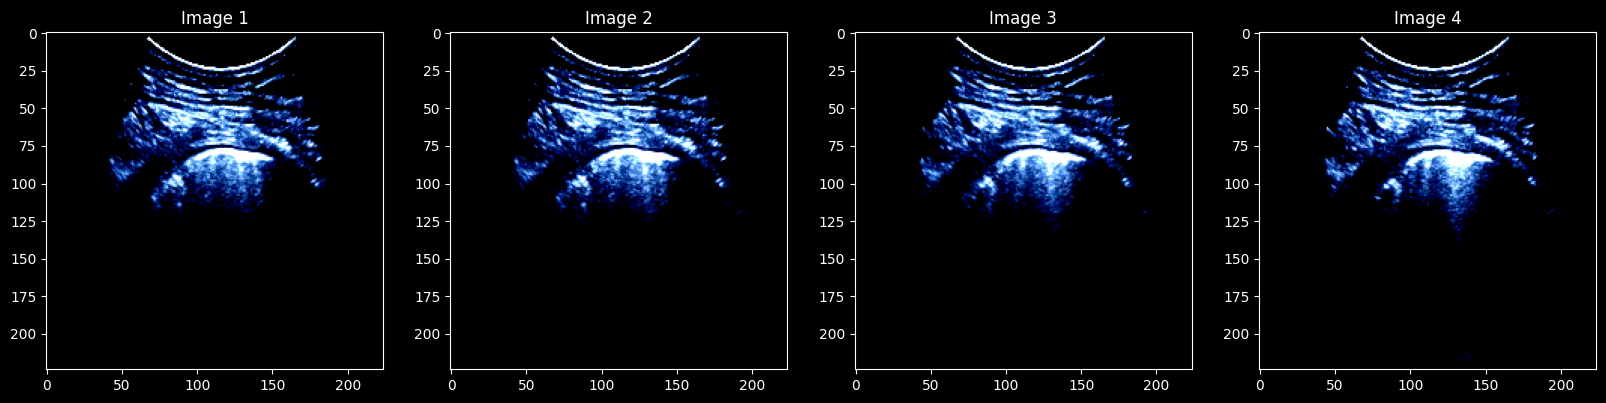

In [23]:
import matplotlib.pyplot as plt
import torchvision

def show_single_batch(data_loader, batch_idx, win_size=(20, 20)):
    # Extract the specific batch by indexing the DataLoader
    for i, (imgs, labels) in enumerate(data_loader):
        if i == batch_idx:
            # Create a subplot for each image in the batch
            num_images = len(imgs)
            plt.figure(figsize=win_size)

            for j in range(num_images):
                plt.subplot(1, num_images, j + 1)
                plt.imshow(tensor_to_image(imgs[j]))  # Convert the tensor to an image
                plt.title(f"Image {j+1}")

            plt.show()
            break
# To display a specific batch (e.g., batch index 0) from the training DataLoader
show_single_batch(train_dataloader, batch_idx=6)


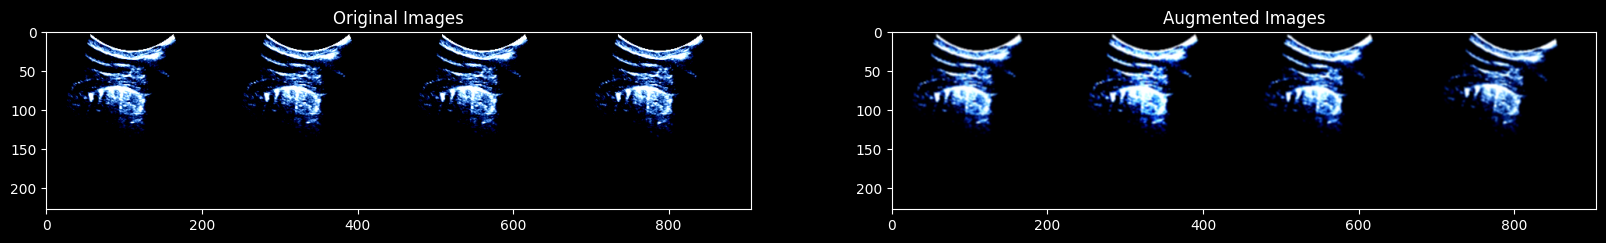

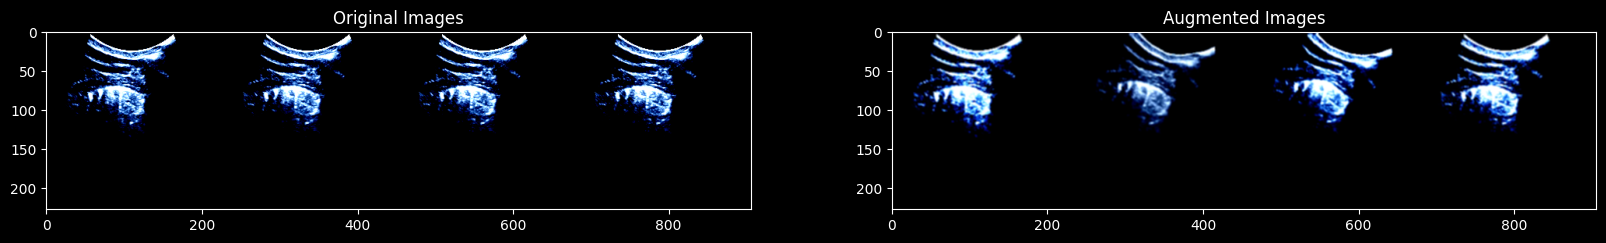

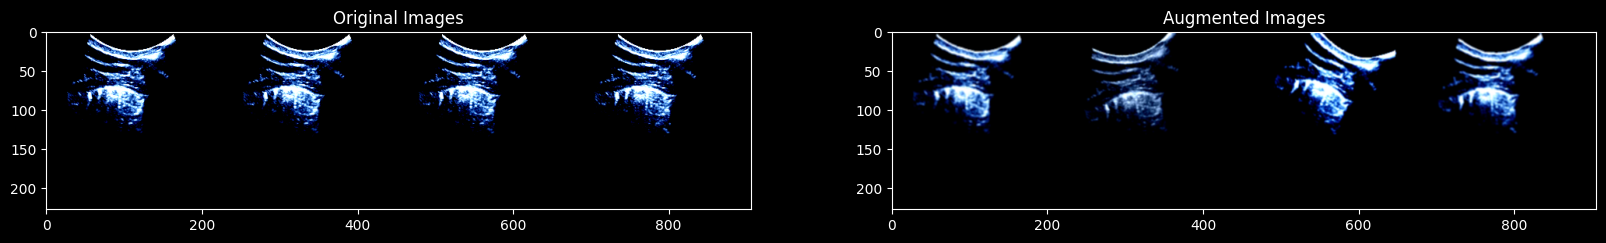

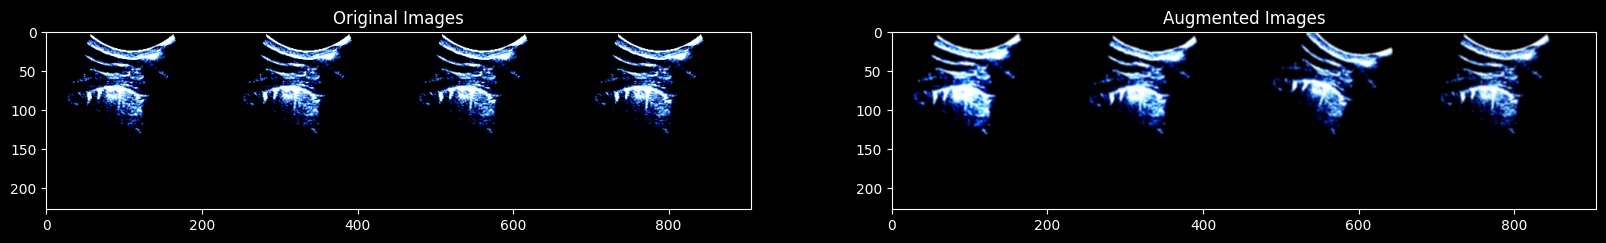

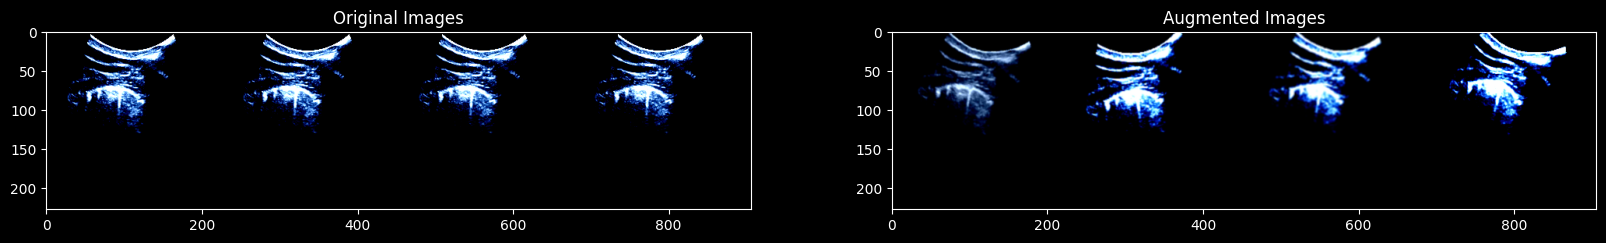

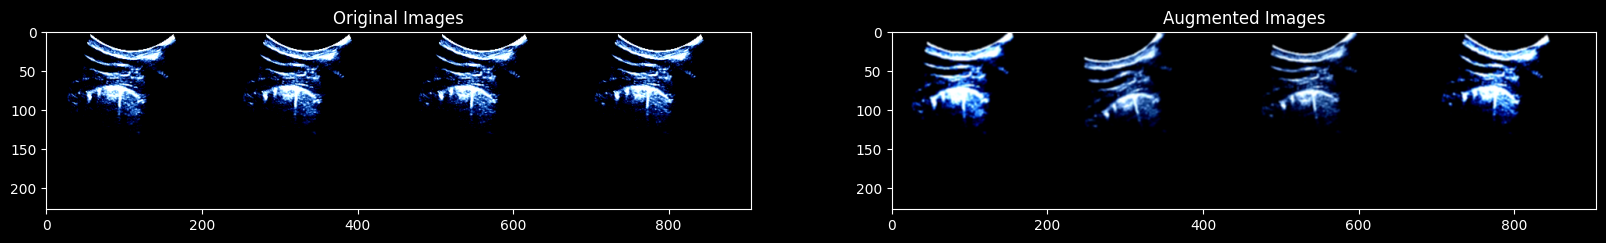

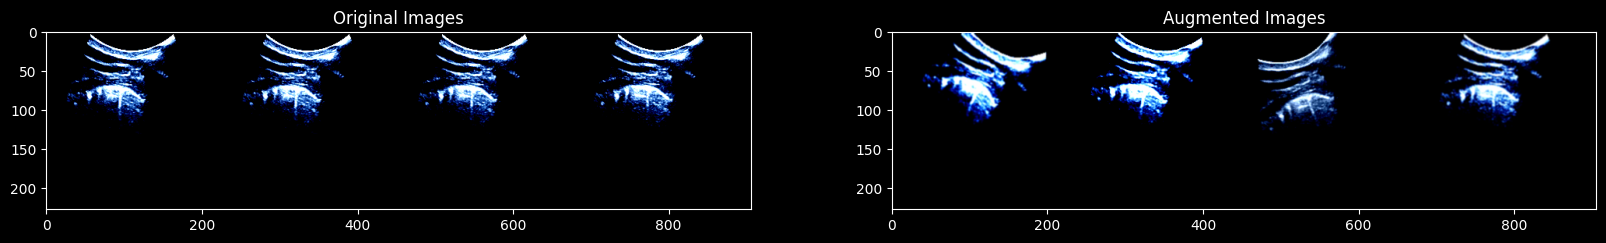

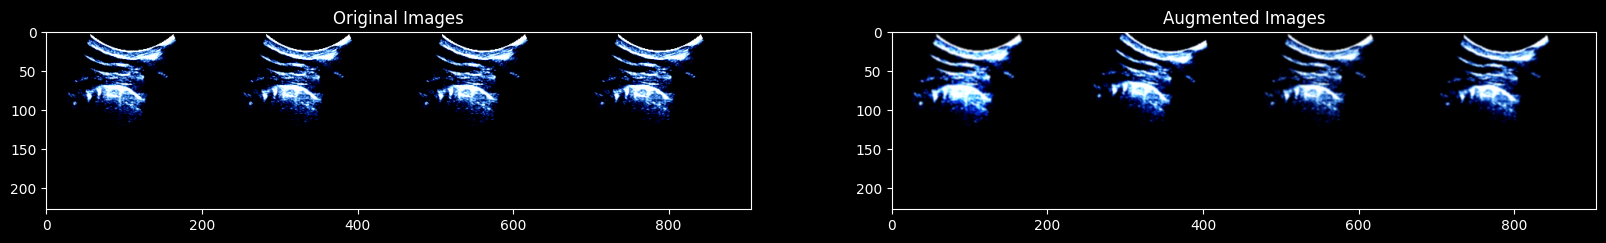

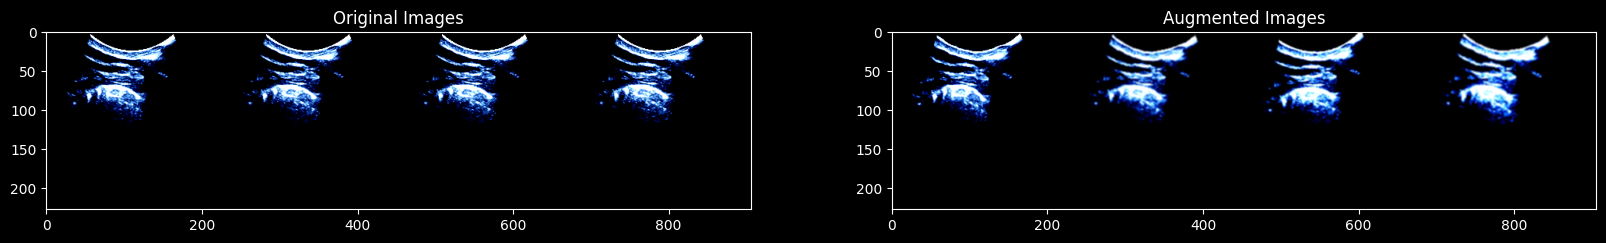

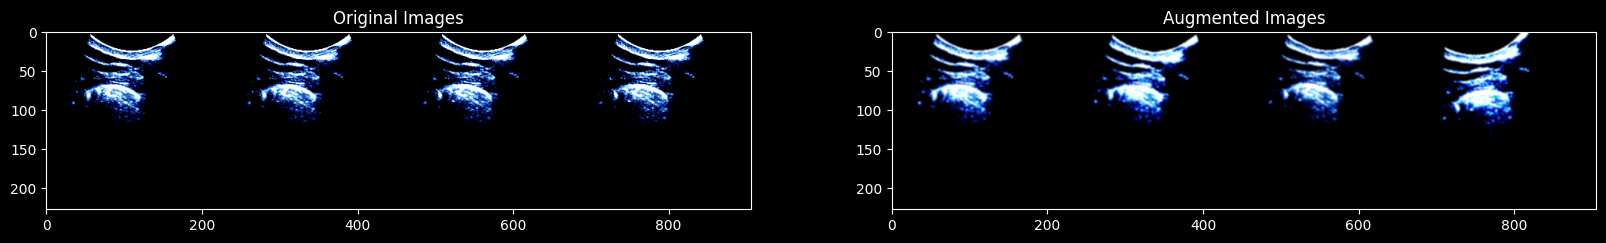

In [24]:

def show_batch(data_loader, num_batches=1, win_size=(20, 20)):
    def _to_vis(data):
        # Ensure that pixel values are in the valid range [0, 1]
        data = torch.clamp(data, 0, 1)
        return tensor_to_image(torchvision.utils.make_grid(data, nrow=8))

    for batch_num, (imgs, labels) in enumerate(data_loader):
        if batch_num >= num_batches:
            break
        
        # Apply data augmentation to the batch (you need to define DataAugmentation function)
        imgs_aug = transform(imgs)

        # Create subplots for original and augmented images
        plt.figure(figsize=win_size)
        plt.subplot(1, 2, 1)
        plt.imshow(_to_vis(imgs))
        plt.title("Original Images")

        plt.subplot(1, 2, 2)
        plt.imshow(_to_vis(imgs_aug))
        plt.title("Augmented Images")

        plt.show()

# To display one batch from the training DataLoader
show_batch(test_dataloader, num_batches=10)